# Header

In [1]:
import os
import cv2
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

import numpy as np
import scipy as s
import scipy.signal as sig

In [2]:
# Check directory
os.chdir("D:\Raphael\Dropbox\Mcgill\JupyterNotebook\PHYS512")
os.getcwd()

'D:\\Raphael\\Dropbox\\Mcgill\\JupyterNotebook\\PHYS512'

# Functions

In [3]:
# returnm some important and used much values of the histogram
def histo_imp_val(rho, edge):
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    minx = edge[0][0] #end of each axes
    miny = edge[1][0]
    minz = edge[2][0]
    return nx,ny,nz,dx,dy,dz,minx,miny,minz

In [111]:
# Define single ptcl softened potential (softened green's function), given a density matrix shape
def soft_pot(rho,edge,a):
    pot =rho*0 #initialise potential matrix
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    for i in range(nx):
        for j in range(ny):
            for k in range(nz): # looking at some bin i,j,k
                x = (i+0.5)*dx-centerx # position of the center of the bin in x, given ptcl at x=0.5 (i.e at the center, since x=[0,1) )
                y = (j+0.5)*dy-centery
                z = (k+0.5)*dz-centerz
                r = np.sqrt(x**2+y**2+z**2+a**2) # distance btw center of bin and and particle
                pot[i,j,k] = 1/r**2
    return pot

In [4]:
# Define single ptcl softened potential (softened green's function), given a density matrix shape
def soft_pot(rho,edge,a):
    pot =rho*0 #initialise potential matrix
    nx = len(rho[0]) # number of bins in x
    ny = len(rho[1])
    nz = len(rho[2])
    dx = edge[0][1]-edge[0][0] # size of bin in x
    dy = edge[1][1]-edge[1][0]
    dz = edge[2][1]-edge[2][0]
    centerx = (edge[0][-1]-edge[0][0])/2 # center of x axis
    centery = (edge[1][-1]-edge[1][0])/2
    centerz = (edge[2][-1]-edge[2][0])/2
    for i in range(nx):
        for j in range(ny):
            for k in range(nz): # looking at some bin i,j,k
                x = (i+0.5)*dx-centerx # position of the center of the bin in x, given ptcl at x=0.5 (i.e at the center, since x=[0,1) )
                y = (j+0.5)*dy-centery
                z = (k+0.5)*dz-centerz
                r = np.sqrt(x**2+y**2+z**2) # distance btw center of bin and and particle
                if r**3<=a:
                    pot[i,j,k] = r/a # potential for bins close to ptcl
                else:
                    pot[i,j,k] = 1/r**2 # potential for bins far from ptcl
    return pot

In [5]:
# return the ijk coordinate of a (ONE) given cell position (x_n)
def x_to_ijk(x_n, rho, edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    x = x_n[0]
    y = x_n[1]
    z = x_n[2]
    i = int(round((x-minx)/dx - 0.5))
    j = int(round((y-miny)/dy - 0.5))
    k = int(round((z-minz)/dz - 0.5))
    #print(i,j,k) #debugging
    return i,j,k

In [6]:
# return the ijk coordinate of a set of (MANY) cell position(x_n)
def xn_to_ijk(x_n, rho, edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    indices = np.zeros(shape=(len(x_n),3))
    for n in range(len(x_n)):
        x = x_n[n][0]
        y = x_n[n][1]
        z = x_n[n][2]
        i = int(round((x-minx)/dx - 0.5))
        j = int(round((y-miny)/dy - 0.5))
        k = int(round((z-minz)/dz - 0.5))
        indices[n]  = (i,j,k)
    #print(i,j,k) #debugging
    return indices

In [7]:
# Order the elements in x_n in order of ascending x, then y, then z
def order_x(x,rho,edge):
    indices = xn_to_ijk(x, rho, edge)
    return x[np.lexsort((np.transpose(indices)[2],np.transpose(indices)[1],np.transpose(indices)[0]))]

In [8]:
def ijk_to_x(i,j,k,rho,edge):
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    return np.array([[(i+0.5)*dx+minx,(j+0.5)*dy+miny,(k+0.5)*dz+minz]])

## Plot functions

In [9]:
# define function for easy visual check (thanks Marcus!)
def plot_2D_collapse(H,edges):
    edges_x = edges[0]
    edges_y = edges[1]
    edges_z = edges[2]
    fig,ax = plt.subplots(figsize=(5,5), dpi=100)
    im = ax.imshow(
        H.sum(axis=2),
        origin="lower",
        extent=(edges_x.min(), edges_x.max(), edges_y.min(), edges_y.max()), 
        aspect="auto")
    ax.set_xlabel("y")
    ax.set_ylabel("x")
    minor_ticks_x = edges_x
    minor_ticks_y = edges_y
    ax.set(xlim=(minor_ticks_y[0], minor_ticks_y[-1]), ylim=(minor_ticks_x[0], minor_ticks_x[-1]))
    ax.set_xticks(minor_ticks_y, minor=True)
    ax.set_yticks(minor_ticks_x, minor=True)

    # colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    
    plt.show

In [10]:
#Return a 3D plot of the given x
def plot_graph3D(x, edge, title ="", scale_factor = 100,save=False, show = True, name = "fig",n = 0, view1=20,view2=60):
    #Create figure
    x = np.transpose(x)
    fig=plt.figure(figsize=(10,10))#Create 3D axes
    ax=Axes3D(fig) 
    ax.scatter(x[0], x[1], x[2], color="royalblue", marker=".",s=.02*scale_factor)
    ax.set_xlabel("x-coordinate",fontsize=14)
    ax.set_ylabel("y-coordinate",fontsize=14)
    ax.set_zlabel("z-coordinate",fontsize=14)
    ax.set_title(title,fontsize=20)
    #ax.legend(loc="upper left",fontsize=14)
    #ax.xaxis.set_ticklabels([])
    #ax.yaxis.set_ticklabels([])
    #ax.zaxis.set_ticklabels([])
    ax.set_xlim3d(edge[0].min(),edge[0].max())
    ax.set_ylim3d(edge[1].min(),edge[1].max())
    ax.set_zlim3d(edge[2].min(),edge[2].max())
    ax.view_init(view1,view2)
    plt.show
    if save:
        plt.savefig('Pictures_Final_Project/{}{}.png'.format(name,str(n).zfill(10)), dpi=100)
    if show  == False:
        plt.close(fig)

## Other functions

In [11]:
def movie_from_image(title = 'project.avi',fps = 15):
    img_array = []
    for filename in glob.glob('{}\\*.png'.format(os.path.join(os.getcwd(), 'Pictures_Final_Project'))):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
 
    out = cv2.VideoWriter(title,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
 
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    
    print('Video finish')
    return 0

## Function doing the simulation

In [12]:
def Energy(x,v,phi,rho,edge,m=1):
    i,j,k = x_to_ijk(x,rho,edge)
    K = 0.5*m*np.sum(v**2)
    P = -0.5*phi[i,j,k]
    return K+P,K,P

In [13]:
# Initialize the NxNxN matrix with the ptcl in it
# Create the density Matrix
# Order the ptcl such that they are in ascending order
# Create the Green's Function
# Compute Potential
def Initialize(x, m, size, a = 0.005, plot_2D = True, plot_3D = False, sc_factor = 10000):
    # Create density matrix rho
    print("Density rho :")
    rho,edge = np.histogramdd(x,bins=size,range=((-1,1),(-1,1),(-1,1)), weights = m)
    if plot_2D: plot_2D_collapse(rho,edge)
    print(" -- COMPLETE --")

    print("Order x :")
    # Order the x in order of ascending x, then y, then z
    x = order_x(x,rho, edge)
    print(" -- COMPLETE --")
    
    # Create softened potential matrix s_pot
    print("Green's Func :")
    greens_f = soft_pot(rho,edge,a)
    if plot_2D: plot_2D_collapse(greens_f,edge)
    print(" -- COMPLETE --")

    # Compute total potential matrix by convolving the density matrix with the softened potential
    # NOTE : the potential phi will be compute once again in Evolve(); this is only for visual check.
    print("Potential :")
    phi = sig.fftconvolve(rho,greens_f,mode='same')
    if plot_2D: plot_2D_collapse(phi,edge)
    print(" -- COMPLETE --")
    
    plot_graph3D(x,edge,scale_factor = sc_factor,save=False,show=plot_3D)
    
    return x, rho, edge, greens_f, phi

In [102]:
# evolve the system for nb_step time
def Evolve(dt, size, nb_step, x_n, m, rho_n, phi_n, rho, edge, greens_f, v_n0, 
           show_freq=1,sc_factor=100,plot_3D = True, plot_E = True, save_3D=False, 
           name_file = "fig", view1=20,view2=60):
    # check for inital velocity. if no inital velocity, set v_0 to 0 for all i,j,k,d
    v_n = v_0*0
    for ptcl in range(len(x_n)):
        i,j,k = x_to_ijk(x_n[ptcl], rho, edge)
        acc_1 = np.transpose(np.gradient(phi_n))
        v_n[ptcl] = v_n0[ptcl] + 0.5*m[ptcl]*acc_1[k,j,i]*dt
    
    # create a array to store the energy values
    E_values = np.zeros(shape=(nb_step+1,3))
    
    for nb in range(nb_step):
        #print("Step :",nb)#, end =" ") # print actual step
        
        # plot the ptcls in a 3D graph
        if nb%show_freq==0:# make an image if the step is a multiple of show_freq.
            plot_graph3D(x_n,edge,title = "Step {}".format(nb), 
                         scale_factor = sc_factor,save=save_3D, show = plot_3D, 
                         name = name_file,n = nb, view1=view1,view2=view2)
            
        # Compute total potential matrix by convolving the density matrix with the softened potential
        phi_n = sig.fftconvolve(rho_n,greens_f,mode='same')
            
        # Compute acceleration
        # NOTE : since I taking the transpose such that acc has dimension NxNxNx3, the indices are now (k,j,i,d).
        acc_n = np.transpose(np.gradient(phi_n))
        
        # set an empty array for v_n1
        v_n1 = v_n*0
        # set an empty array for x_n1
        x_n1 = x*0         
        
        # Set energy to 0 (will be compute in the following for loop)
        E = np.zeros(3)
        for ptcl in range(len(x_n)): #for all ptcl in x_n
            E = E + Energy(x_n[ptcl],v_n,phi_n,rho_n,edge)
            i,j,k = x_to_ijk(x_n[ptcl], rho, edge)# get the ptcl position in the matrix
            x_n1[ptcl] = x_n[ptcl] + v_n[ptcl]*dt #update that said ptcl position
            v_n1[ptcl] = v_n[ptcl] + m[ptcl]*acc_n[k,j,i]*dt
            #for d in range(3): x_n1[ptcl][d] = (x_n1[ptcl][d]-1)%2-1
            #print(acc_n[k,j,i], end =" ")
            #print(v_n[ptcl], end =" ")
            #print(v_n1[ptcl])
        x_n1 = (x_n1-1)%2-1 #Assures that the ptcl is inside the boundaries of the box (-1,1)
        
        # Create density matrix rho for step n1
        rho_n1,edge = np.histogramdd(x_n1,bins=size,range=((-1,1),(-1,1),(-1,1)), weights = m)
    
        # print the energy beside the the step number, and record its value in E_values
        #print("E=",E[0],"  K=",E[1],"  P=",E[2])
        E_values[nb] = E
    
        # plot the next step ptcls in a 3D graph iff we are in the last step
        if nb == nb_step-1:
            phi_n1 = sig.fftconvolve(rho_n1,greens_f,mode='same')
            print("Step :",nb+1, end =" ")
            E = np.zeros(3)
            for ptcl in range(len(x_n)):
                E = E + Energy(x_n[ptcl],v_n,phi_n,rho_n,edge)
            #print("E=",E[0],"  K=",E[1],"  P=",E[2])
            E_values[nb+1] = E
            plot_graph3D(x_n,edge,title = "Step {}".format(nb), 
                         scale_factor = sc_factor,save=save_3D, show = plot_3D, 
                         name = name_file,n = nb+1, view1=view1,view2=view2)
    
        # UPDATE THE VARIABLE FROM STEP n TO n+1 --------------------------------
        x_n = x_n1
        rho_n = rho_n1
        v_n = v_n1
    
    # plot the energy
    if plot_E:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
        ax1.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[0],"bo-", label="E")
        ax2.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[1],"ro-", label="K")
        ax3.plot(np.linspace(0,nb_step,nb_step+1),np.transpose(E_values)[2],"go-", label="P")
        fig.legend()
        plt.show()

# === === === CODE === === ===

Density rho :
 -- COMPLETE --
Order x :
 -- COMPLETE --
Green's Func :
 -- COMPLETE --
Potential :
 -- COMPLETE --


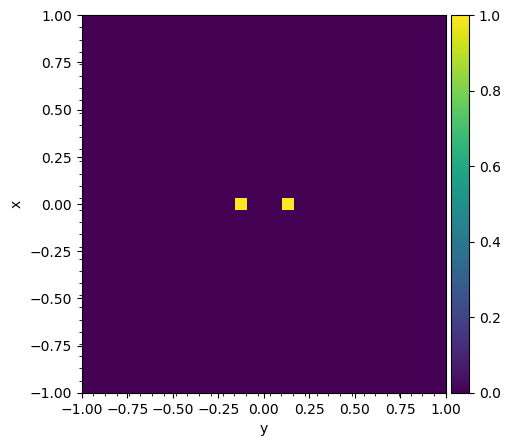

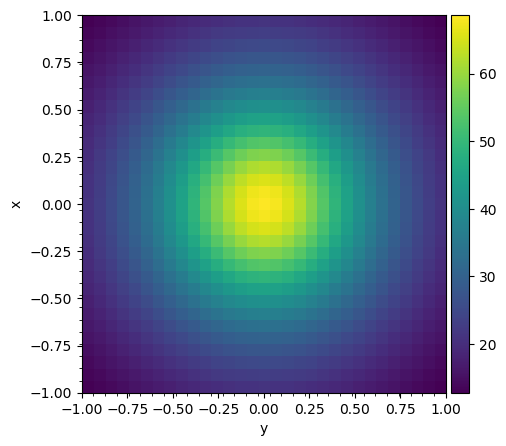

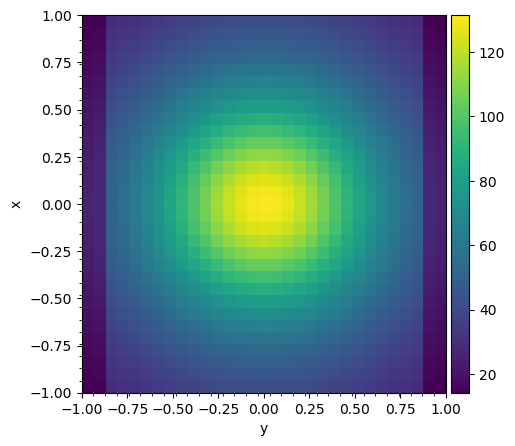

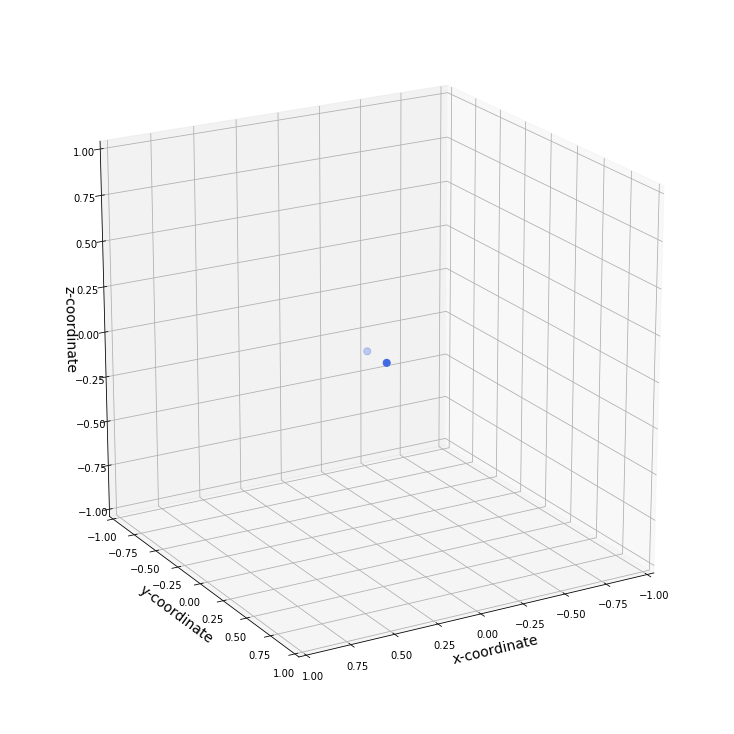

In [128]:
# set inital parameters
N = 4
size = 31
dt = 0.01
nb_step = 200

# set the ptcls
x_select = 2
if x_select == 0: 
    x=np.random.rand(N,3)*2-1 #Random N ptcl
    v_0=x*0
    m = x/x
if x_select == 1: 
    x=np.array([[0.0,0.0,0.0]]) # Ptcl in the center
    v_0=x*0
    m = np.array([1.0])
if x_select == 2: 
    speed = 2.0
    x=np.array([[0.0,-0.1,0.0],[0.0,0.1,0.0]]) # Pair of particles
    v_0=np.array([[-speed,0.0,0.0],[speed,0.0,0.0]]) # speed of each particle.
    m=np.array([1.0,1.0])
    
# Initilise the system
x, rho, edge, greens_f, phi = Initialize(x, m, size,a=0.5,plot_2D=True, plot_3D=True,sc_factor = 10000)

Step : 200 

C:\Users\Raphael\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
C:\Users\Raphael\Anaconda3\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


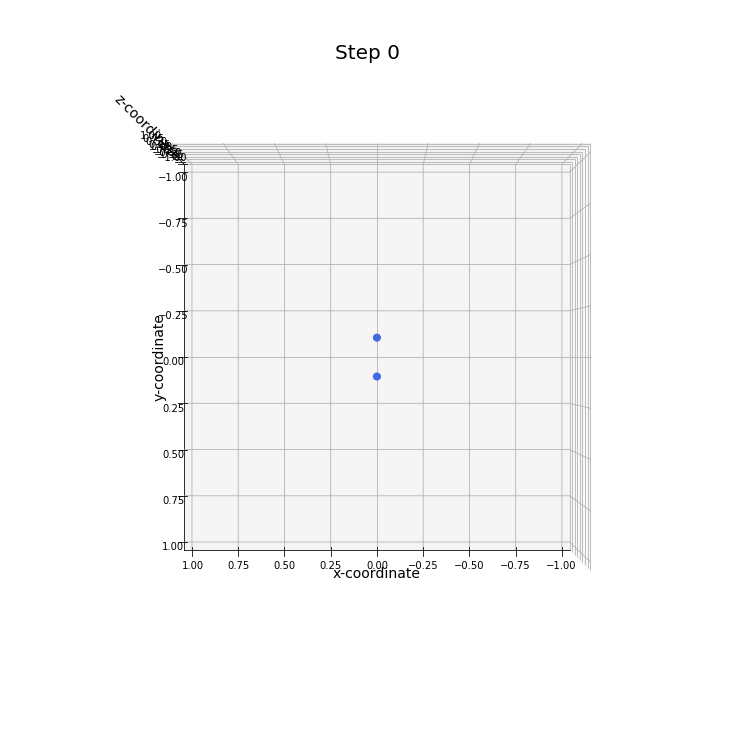

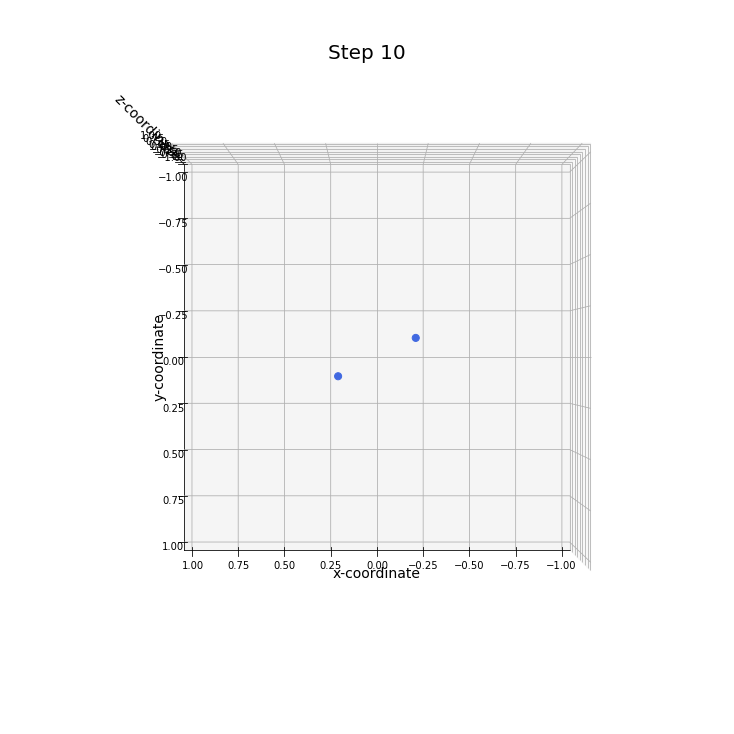

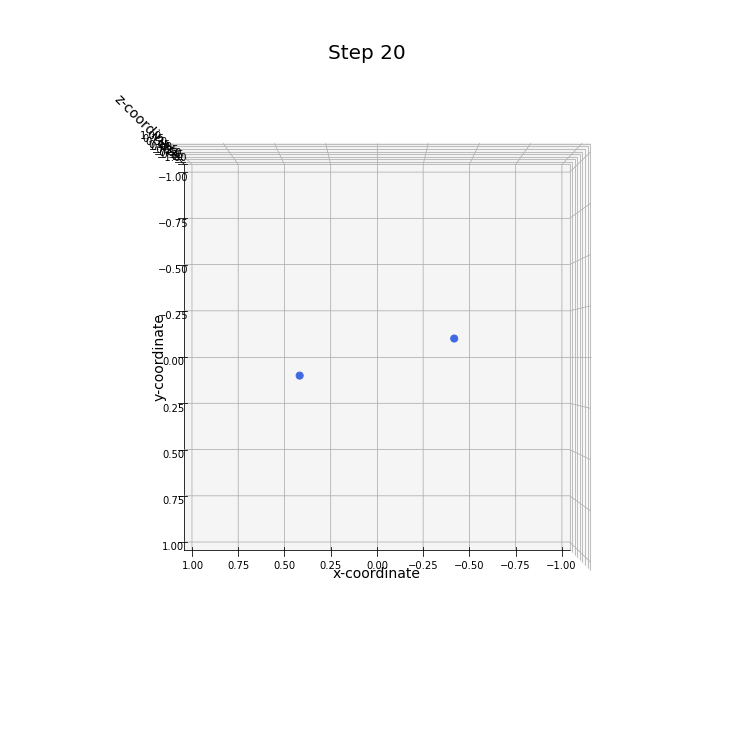

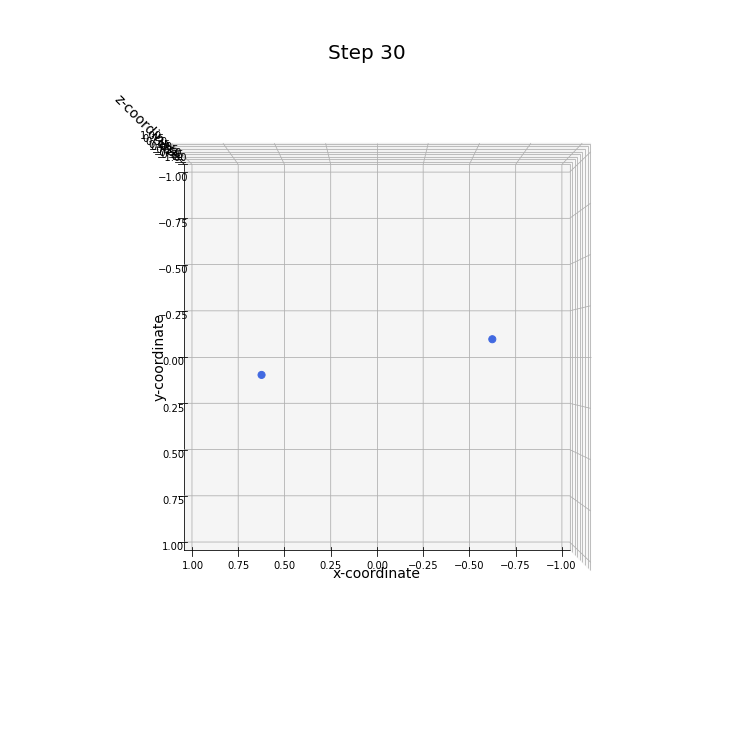

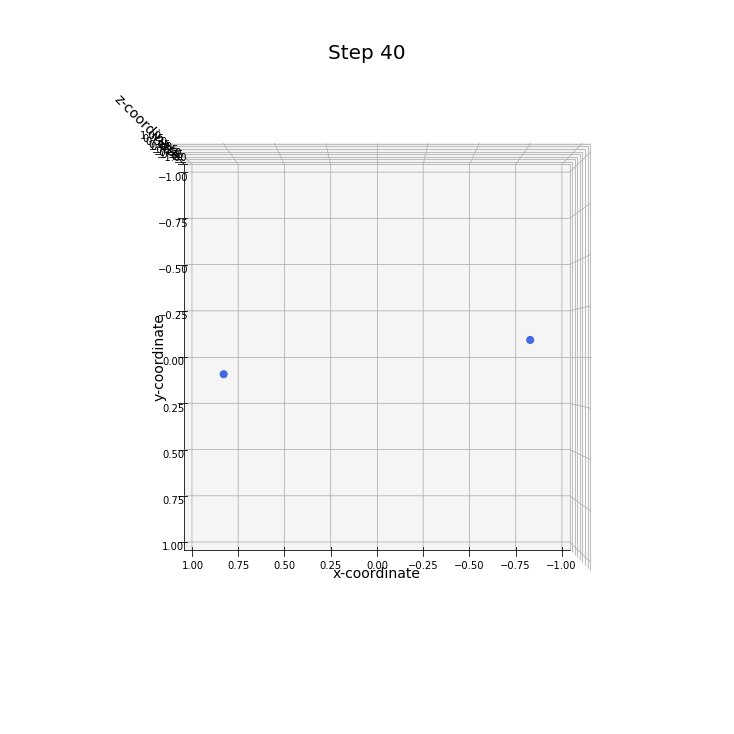

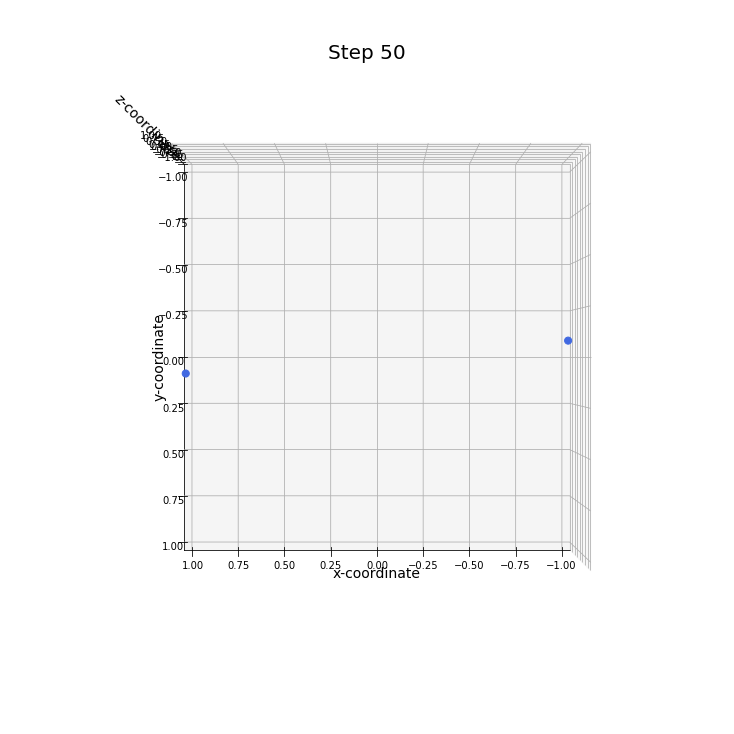

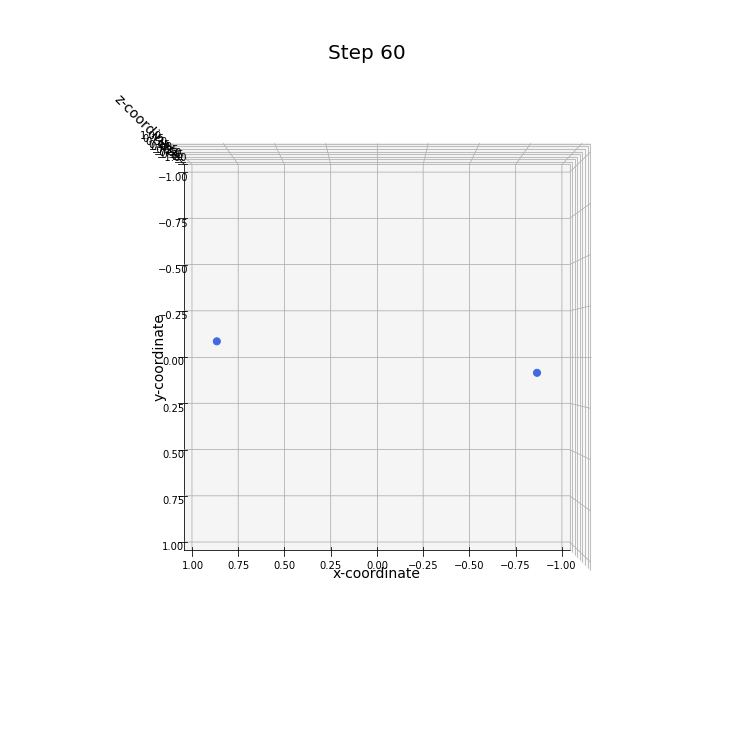

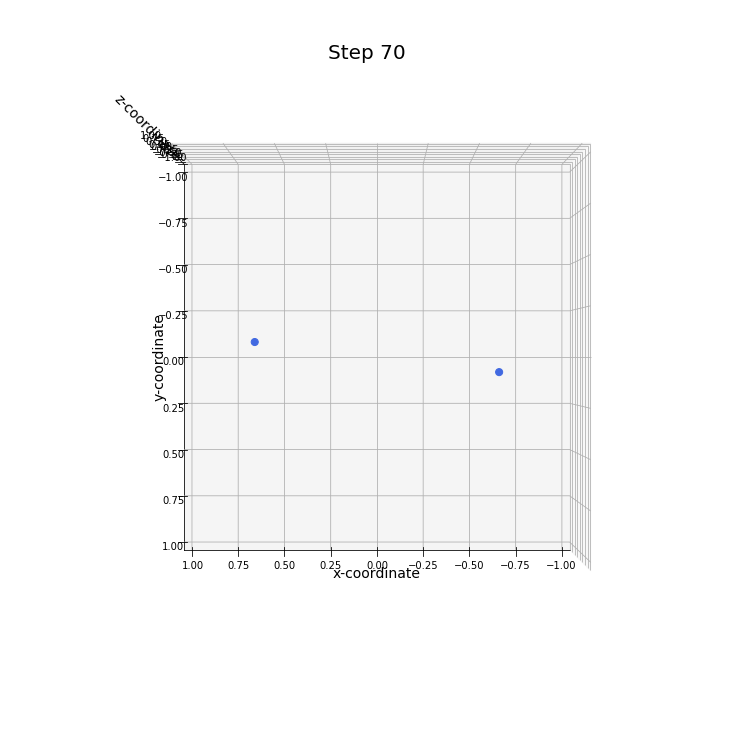

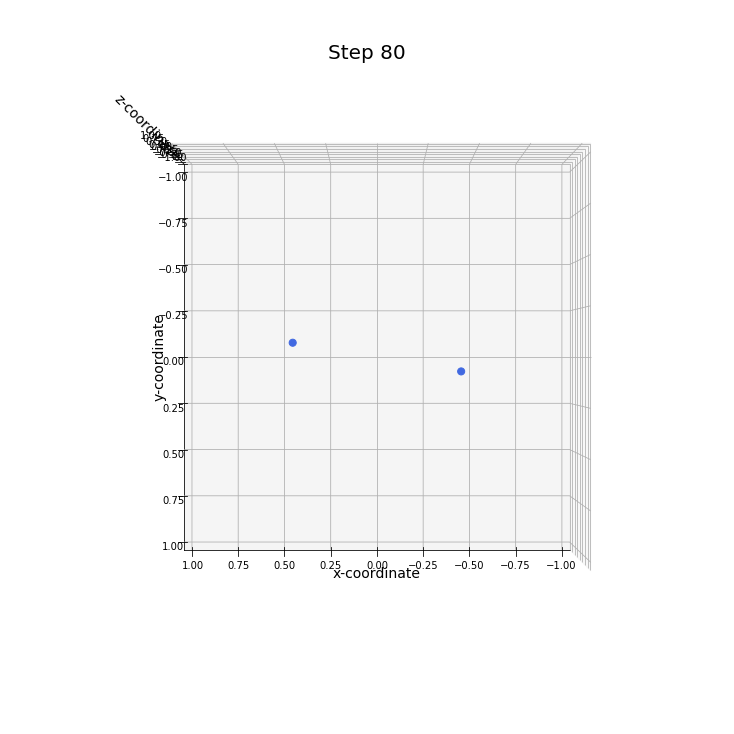

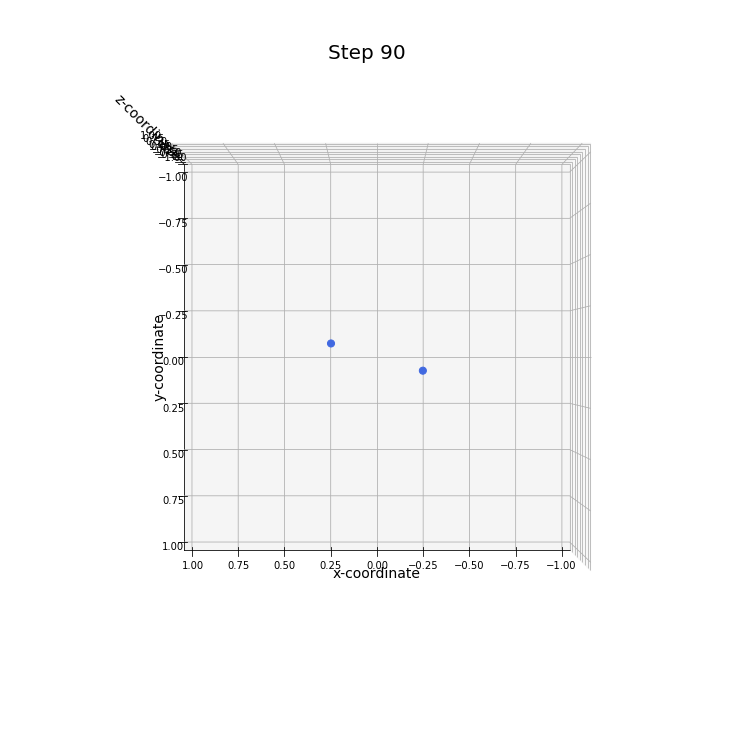

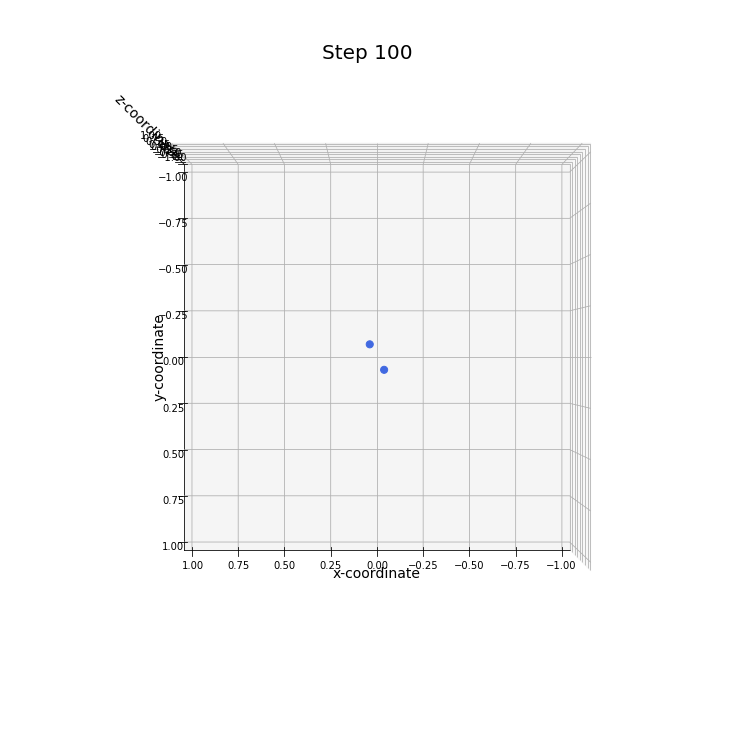

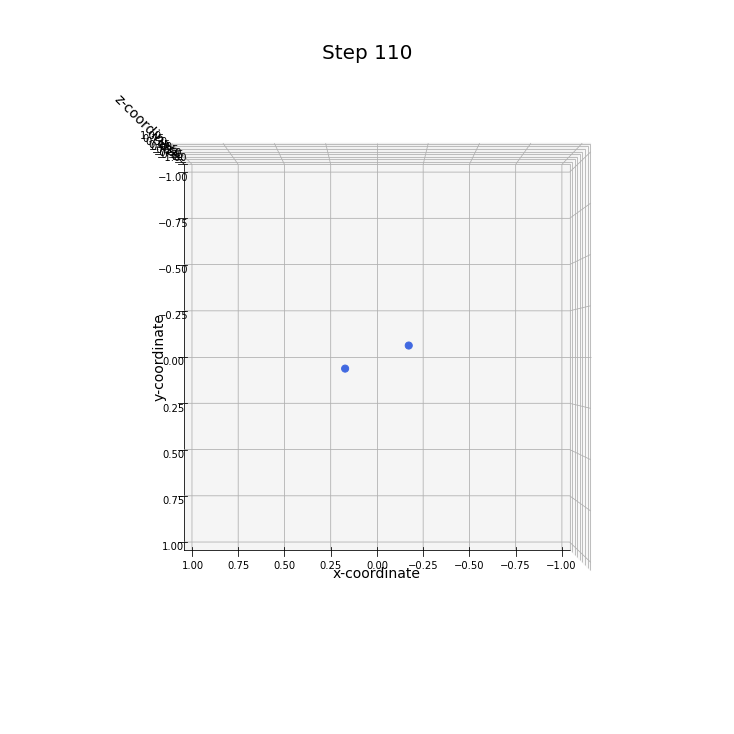

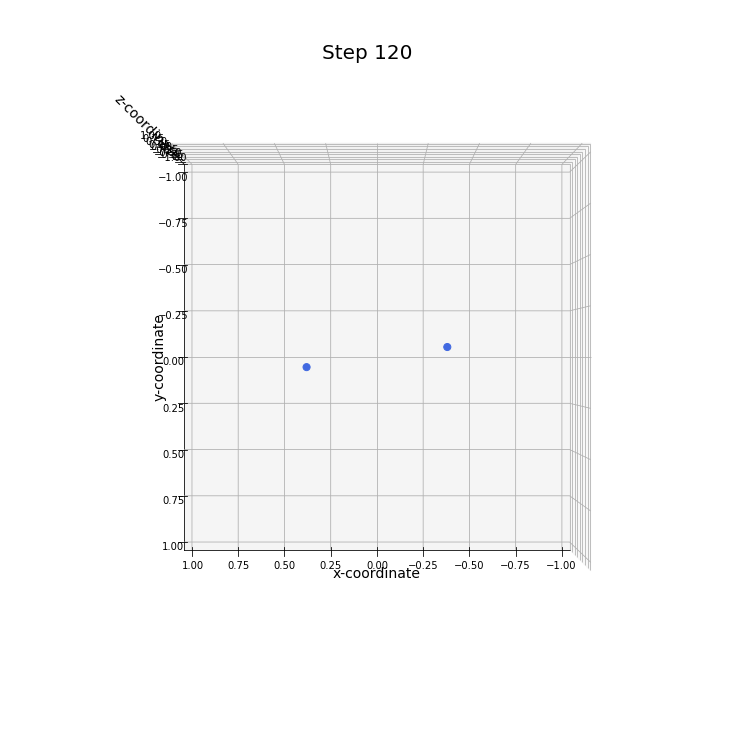

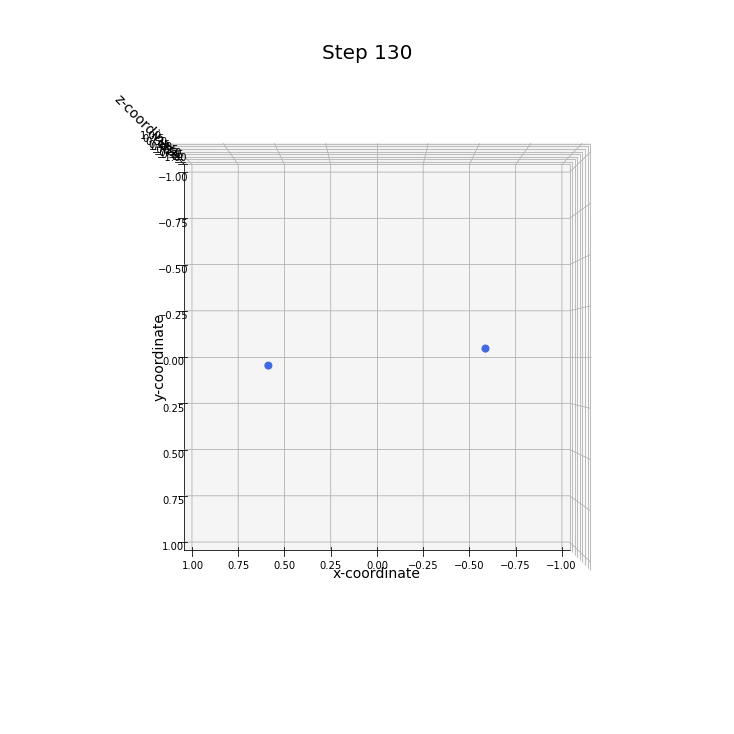

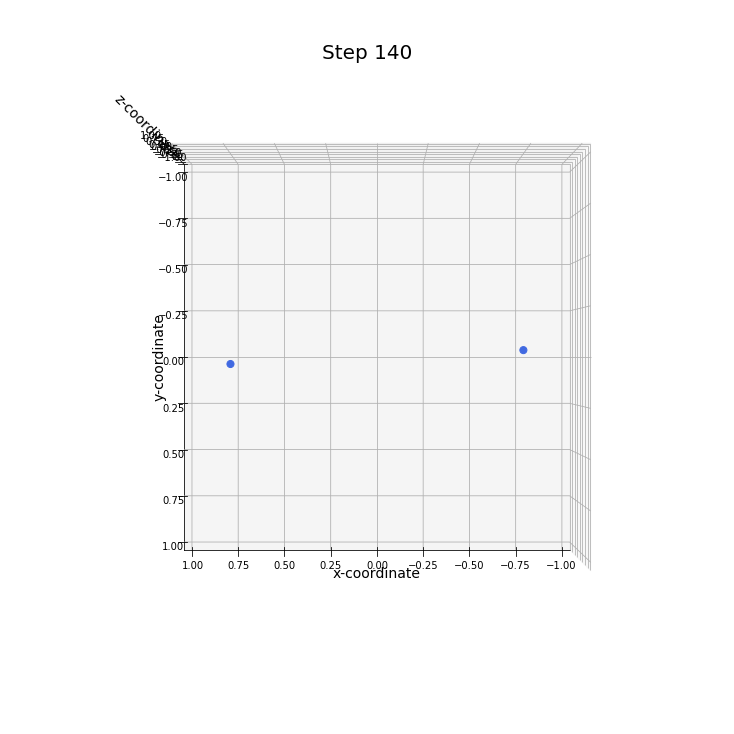

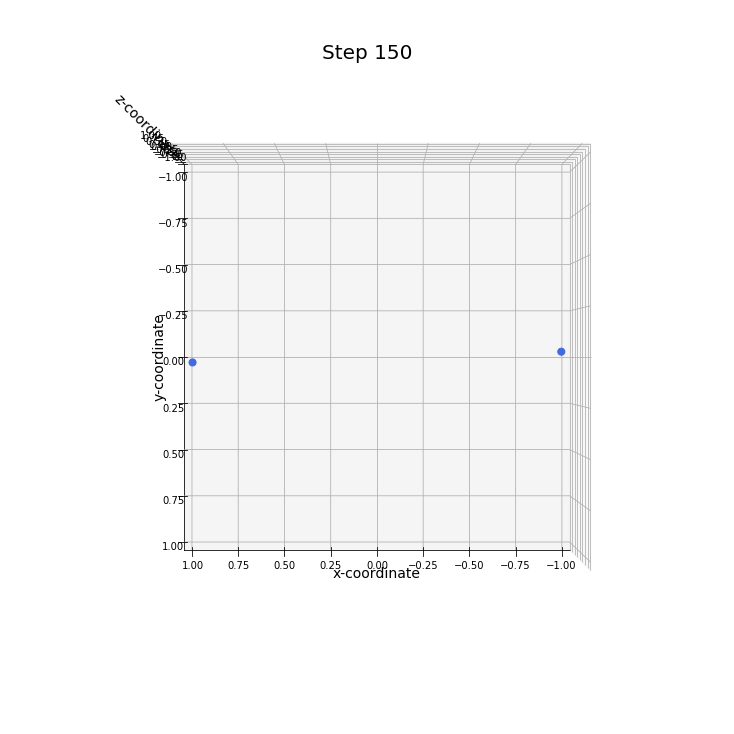

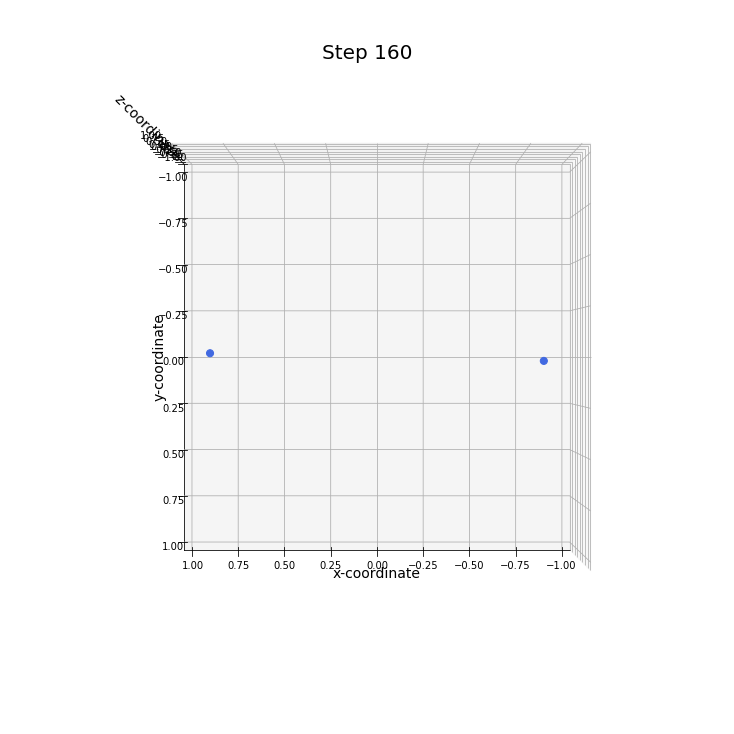

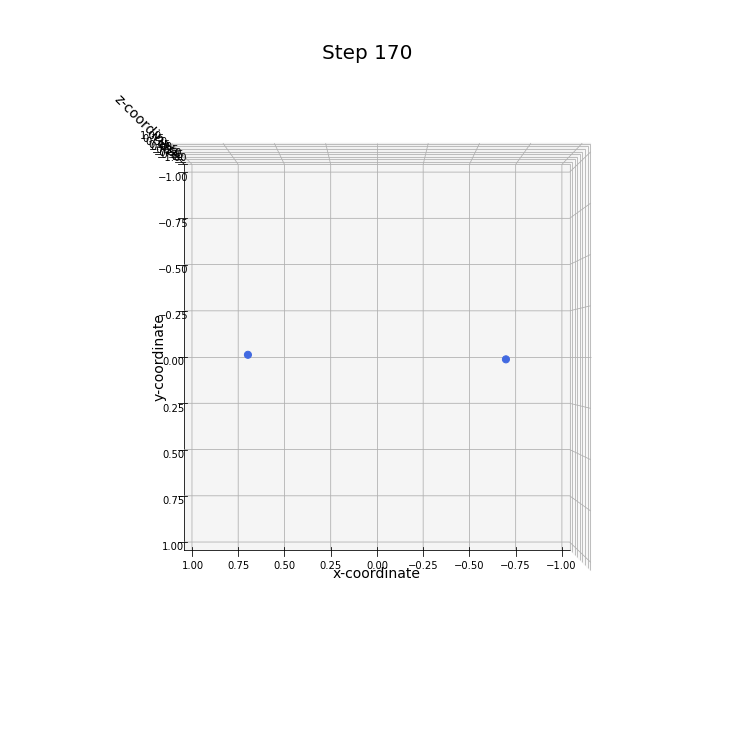

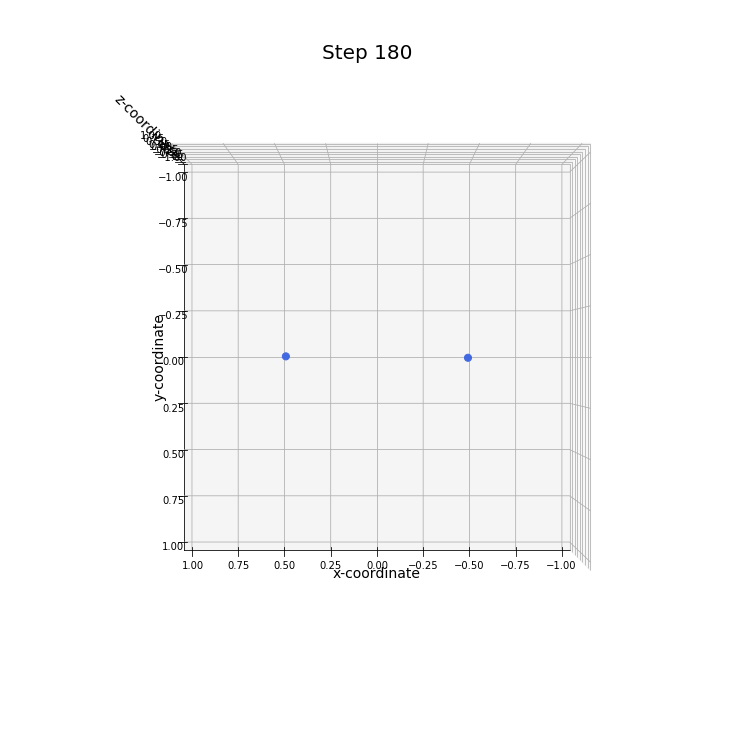

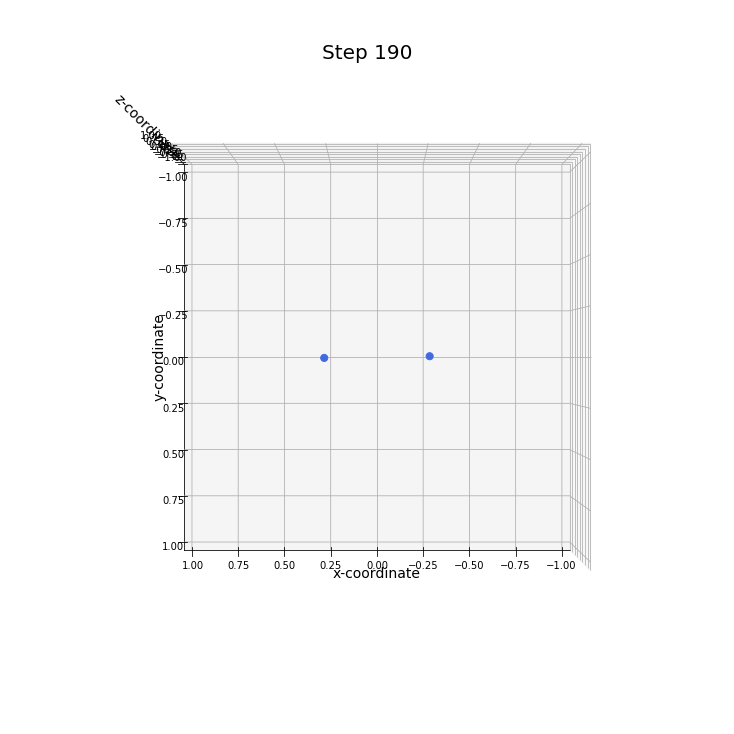

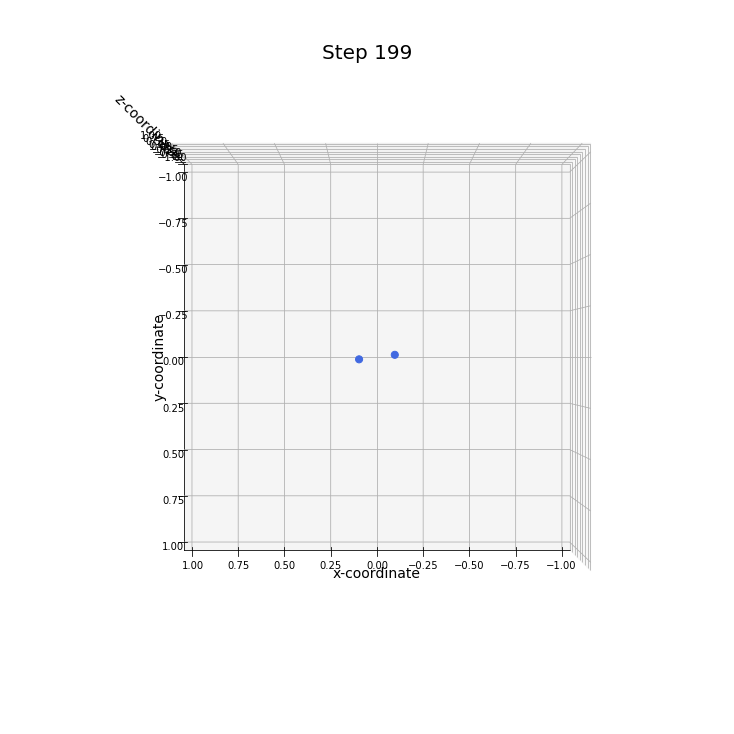

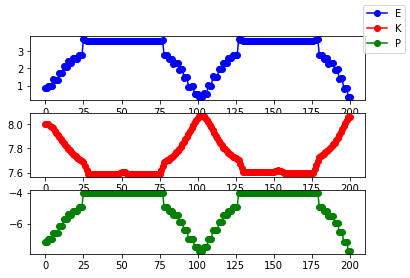

In [129]:
Evolve(dt, size, nb_step, x, m, rho, phi, rho, edge, greens_f, v_0, 
       show_freq=10,sc_factor=10000,plot_3D = True, save_3D=False, name_file = "fig", view1=90, view2=90)  

In [123]:
movie_from_image(title = 'project.avi',fps = 5)

Video finish


0

In [ ]:
# Allow to transform the rho nxnxn matrix to a nx3 matrix of all the points position,
# thus allowing us to plot it using plot_graph3D()
def rho_to_x(rho):
    x = np.array([[0,0,0]])
    nx,ny,nz,dx,dy,dz,minx,miny,minz = histo_imp_val(rho, edge)
    for i in range(nx):
        #print("i=",i) #Debugging
        for j in range(ny):
            for k in range(nz):
                if rho[i,j,k] != 0.:
                    for nb_ptcl in range(int(rho[i,j,k])):
                        position = np.array([[(i+0.5)*dx+minx,(j+0.5)*dy+miny,(k+0.5)*dz+minz]])# obtain position
                        x = np.concatenate((x,position),axis=0)# add it to the list of points x
                    
    return x[1:] #removes the first dummy point [0,0,0] and return x